<a href="https://colab.research.google.com/github/YonggunJung/colab/blob/main/DLotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
win = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/로또/data/jlotto.csv', delimiter = ',')
win

array([[ 4.,  7., 17., 18., 38., 44.],
       [ 8., 12., 13., 29., 33., 42.],
       [ 3.,  7., 14., 15., 22., 38.],
       ...,
       [ 6.,  7., 13., 28., 36., 42.],
       [13., 14., 22., 26., 37., 38.],
       [10., 12., 29., 31., 40., 44.]])

In [ ]:
xn = len(win)

In [ ]:
# 숫자를 원핫 인코딩으로 변환
def n2o(numbers):

  oh = np.zeros(45)  # 45개의 빈 칸 만들기

  for i in range(6):            # 6개의 당첨번호를 반복
      oh[int(numbers[i])-1] = 1   # 번호는 1부터 시작하고 인덱스는 0부터 시작하니 1을 빼줌

  return oh

# 원핫 인코딩을 숫자로 변환
def o2n(oh):

  numbers = []

  for i in range(len(oh)):
    if oh[i] == 1:           # oh[i]이 1 이면 해당 번호를 출력
      numbers.append(i+1)    # 인덱스 보다 숫자가 1크니까 1더해줌 출력

  return numbers

In [ ]:
numbers = win[: , :]  # 이게 문제라서 못 하겠음ㅠ 데이터 프레임이 문제인가?
                      # 데이터 프레임으로 안열고 넘파이 텍스트 파일로 가져오니 됨
ohs = list(map(n2o, numbers))

xs = ohs[0:xn -1]
ys = ohs[1:xn]

# 원핫 인코딩 확인
print('ohs')
print('x[0] :' + str(xs[0]))
print('y[0] :' + str(ys[0]))

# 번호 확인
print('numbers')
print('x[0] :' + str(o2n(xs[0])))
print('y[0] :' + str(o2n(ys[0])))

ohs
x[0] :[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
y[0] :[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
x[0] :[4, 7, 17, 18, 38, 44]
y[0] :[8, 12, 13, 29, 33, 42]


In [ ]:
train = (0, int(len(win)*0.6))
val = (int(len(win)*0.6), int(len(win)*0.8))
test = (int(len(win)*0.8), len(win))

print('train : {0}, val : {1}, test : {2}'.format(train, val, test))

train : (0, 661), val : (661, 882), test : (882, 1103)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델 정의
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape = (1, 1, 45),
                      return_sequences = False,
                      stateful = True),
    keras.layers.Dense(45, activation = 'sigmoid')
])

# 모델 컴파일
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):
    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []

    for i in range(train[0], train[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val[0], val[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.test_on_batch(xss, yss) # 배치만큼 모델에 입력하여 나온 결과를 정답과 비교함

        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}, val_acc {3:0.3f}, val_loss {4:0.3f}'.format(epoch,
                                                                                                  np.mean(batch_train_acc),
                                                                                                  np.mean(batch_train_loss),
                                                                                                  np.mean(batch_val_acc),
                                                                                                  np.mean(batch_val_loss)))

epoch   0, acc 0.026, loss  0.411, val_acc 0.000, val_loss 0.400
epoch   1, acc 0.021, loss  0.396, val_acc 0.000, val_loss 0.399
epoch   2, acc 0.021, loss  0.394, val_acc 0.000, val_loss 0.399
epoch   3, acc 0.035, loss  0.391, val_acc 0.005, val_loss 0.399
epoch   4, acc 0.038, loss  0.388, val_acc 0.018, val_loss 0.401
epoch   5, acc 0.044, loss  0.383, val_acc 0.023, val_loss 0.403
epoch   6, acc 0.050, loss  0.377, val_acc 0.032, val_loss 0.407
epoch   7, acc 0.061, loss  0.370, val_acc 0.036, val_loss 0.410
epoch   8, acc 0.071, loss  0.364, val_acc 0.045, val_loss 0.414
epoch   9, acc 0.076, loss  0.357, val_acc 0.045, val_loss 0.419
epoch  10, acc 0.082, loss  0.350, val_acc 0.045, val_loss 0.423
epoch  11, acc 0.088, loss  0.343, val_acc 0.041, val_loss 0.429
epoch  12, acc 0.100, loss  0.335, val_acc 0.041, val_loss 0.434
epoch  13, acc 0.112, loss  0.327, val_acc 0.041, val_loss 0.439
epoch  14, acc 0.118, loss  0.318, val_acc 0.032, val_loss 0.445
epoch  15, acc 0.126, los

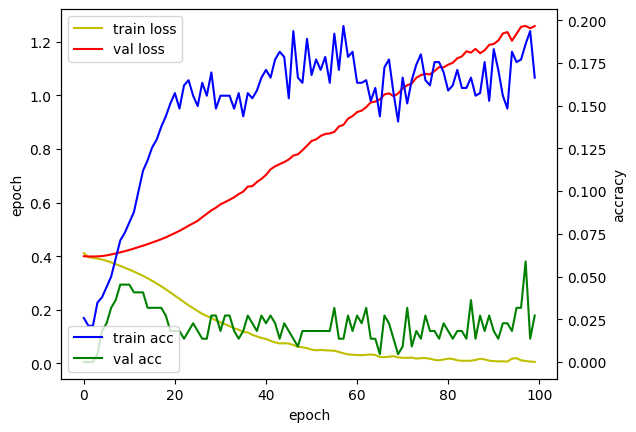

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label = 'train loss')
loss_ax.plot(val_loss, 'r', label = 'val loss')

acc_ax.plot(train_acc, 'b', label = 'train acc')
acc_ax.plot(val_acc, 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('epoch')
acc_ax.set_ylabel('accracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()
# 이미 학습은 의미가 없다는 결론이 나옴

In [ ]:
# 모든 데이터를 학습용으로 사용
for epoch in range(100):

    model.reset_states()  # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(xs)):

      xss = xs[i].reshape(1, 1, 45)
      yss - ys[i].reshape(1, 45)

      loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

      batch_train_loss.append(loss)
      batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}'.format(epoch,
                                                            np.mean(batch_train_acc),
                                                            np.mean(batch_train_loss)
                                                            ))



epoch   0, acc 0.091, loss  0.017
epoch   1, acc 0.077, loss  0.011
epoch   2, acc 0.075, loss  0.008
epoch   3, acc 0.075, loss  0.006
epoch   4, acc 0.075, loss  0.005
epoch   5, acc 0.076, loss  0.004
epoch   6, acc 0.077, loss  0.004
epoch   7, acc 0.079, loss  0.003
epoch   8, acc 0.081, loss  0.003
epoch   9, acc 0.082, loss  0.003
epoch  10, acc 0.084, loss  0.002
epoch  11, acc 0.086, loss  0.002
epoch  12, acc 0.087, loss  0.002
epoch  13, acc 0.089, loss  0.002
epoch  14, acc 0.091, loss  0.002
epoch  15, acc 0.092, loss  0.002
epoch  16, acc 0.094, loss  0.002
epoch  17, acc 0.096, loss  0.002
epoch  18, acc 0.098, loss  0.001
epoch  19, acc 0.099, loss  0.001
epoch  20, acc 0.101, loss  0.001
epoch  21, acc 0.103, loss  0.001
epoch  22, acc 0.105, loss  0.001
epoch  23, acc 0.106, loss  0.001
epoch  24, acc 0.108, loss  0.001
epoch  25, acc 0.109, loss  0.001
epoch  26, acc 0.111, loss  0.001
epoch  27, acc 0.112, loss  0.001
epoch  28, acc 0.113, loss  0.001
epoch  29, acc

In [ ]:
# 다음회 예측

print('receive numbers')

xss = xs[-1].reshape(1, 1, 45)

pred = model.predict_on_batch(xss)
pred

luck = list(map(o2n, pred))
luck

# list_number = []

# for n in range(6):
#   numbers =pred
  # numbers.sort()
  # print('{0} : {1}'.format(n, numbers))
  # list_numbers.append(numbers)

receive numbers


[[1, 3, 11, 24, 30, 32]]

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/로또/data/lotto.csv')
# df

In [ ]:
# Xtrain = df.drop(['일', '이', '삼', '사','오', '육'], axis = 1)
# Xtrain

In [ ]:
# Xtest = Xtrain.iloc[Xtrain.index[-1]]
# Xtest

In [ ]:
# Xtrain.drop(Xtrain.index[-1], inplace = True)
# Xtrain

In [ ]:
# ytrain = df.drop(['1', '2', '3', '4','5', '6'], axis = 1)
# ytrain

In [ ]:
# ytrain.dropna(inplace = True)
# ytrain

In [ ]:
# ytrain =ytrain.astype(int)
# ytrain

In [ ]:
from pandas import get_dummies

Xtrain = pd.get_dummies(Xtrain)
Xtest = pd.get_dummies(Xtest)
Xtest

NameError: name 'Xtrain' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

# 신경망 설계
# 신경망 모델을 관리하는 객체 생성
# 여기에 층을 쌓는다
model = Sequential()

# Dense : 선형 회귀를 수행하는 layer
# 첫번재 숫자는 은닉층의 노드의 개수
model.add(Dense(30, input_dim = 17))
model.add(Activation('relu'))

# 마지막에 설정한 레이어는 무조건 출력층
# Dense의 1은 출력 데이터의 종류 수가 됨
model.add(Dense(1))
model.add(Activation('softmax'))

In [ ]:
# 신경망 모델 컴파일
# loss : 학습시 수행하는 평가때 사용할 손실 함수(오차를 보는 함수)
# 2진 분류 : binary _corssentropy
# 회귀 : mean_squared_error

# opimizer : loss에서 설정한 함수를 통해 구한 손실 값을 기반으로 신경망 보델을
# adam
# otimizer : loss에서 설정한 함수를 통해 구한 손실값을 기반으로 신경망 모델을 보정하는 함수

# metrics : 추가로 평가하고자 하는 평가 기준 설정
# 분류인 경우에만 사용하고 정도화를 추가 적으로 보기 위해 설정
# metrict : 추가로 평가하고자 하는 평가 기준 설정
model.compile(loss = 'categorical', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
#학습
# epochs : 학습 횟수. 너무 많으면 과적합됨.
# 무조건 많이 줘라 나중에 중단 가능
# batch_size : 메모리에 한번에 올릴 데이터의 양(행의 개수) 적게 주면 메모리에 여우가 있지만 오래걸림
# 무조건 많이 넣어주고 오류나면 낮춤
model.fit(Xtrain, ytrain, epochs = 30, batch_size = 10)